In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import infer, poutine
from pyro.infer.autoguide import AutoNormal
from pyro.nn.module import PyroParam, PyroModule, PyroSample
from pyro.contrib.gp import Parameterized
plt.style.use("seaborn-v0_8")

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
co2_df = pd.read_csv("/mnt/dl/machine_learning_dataset/atmospheric_co2_mauna_loa/monthly_in_situ_co2_mlo.csv",
                     skiprows=57)

In [3]:
co2_df

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled,NaN
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958,03,21259,1958.2027,315.71,314.44,316.19,314.91,315.71,314.44,MLO
...,...,...,...,...,...,...,...,...,...,...,...
789,2023,08,45153,2023.6219,419.56,421.11,419.58,421.18,419.56,421.11,MLO
790,2023,09,45184,2023.7068,418.07,421.57,417.96,421.48,418.07,421.57,MLO
791,2023,10,45214,2023.7890,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
792,2023,11,45245,2023.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO


In [4]:
co2_df.columns

Index(['  Yr', ' Mn', '    Date', '      Date', '     CO2', 'seasonally',
       '        fit', '  seasonally', '      CO2', ' seasonally', ' Sta'],
      dtype='object')

In [5]:
co2_df = co2_df.loc[2:,['  Yr', ' Mn', '     CO2',]]

In [6]:
new_cols = list(map(lambda x: x.strip(), co2_df.columns))

In [7]:
new_cols 

['Yr', 'Mn', 'CO2']

In [8]:
co2_df = co2_df.rename(columns=dict(zip(co2_df.columns, new_cols)))

In [9]:
co2_df

,Yr,Mn,CO2
2,1958,01,-99.99
3,1958,02,-99.99
4,1958,03,315.71
5,1958,04,317.45
6,1958,05,317.51
...,...,...,...
789,2023,08,419.56
790,2023,09,418.07
791,2023,10,-99.99
792,2023,11,-99.99


In [10]:
co2_df.Yr = co2_df.Yr.astype(int)
co2_df.Mn = co2_df.Mn.astype(int)
co2_df.CO2 = co2_df.CO2.astype(float)

In [11]:
# Drop Missing
data = co2_df.copy()
data = data[data["CO2"] != -99.99]

In [12]:
data

,Yr,Mn,CO2
4,1958,3,315.71
5,1958,4,317.45
6,1958,5,317.51
8,1958,7,315.87
9,1958,8,314.93
...,...,...,...
786,2023,5,423.78
787,2023,6,423.39
788,2023,7,421.62
789,2023,8,419.56


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 782 entries, 4 to 790
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Yr      782 non-null    int64  
 1   Mn      782 non-null    int64  
 2   CO2     782 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 24.4 KB


In [14]:
data["date"] = data.apply(lambda x: f"{int(x['Yr'])}-{int(x['Mn']):02d}", axis=1)

In [15]:
data

,Yr,Mn,CO2,date
4,1958,3,315.71,1958-03
5,1958,4,317.45,1958-04
6,1958,5,317.51,1958-05
8,1958,7,315.87,1958-07
9,1958,8,314.93,1958-08
...,...,...,...,...
786,2023,5,423.78,2023-05
787,2023,6,423.39,2023-06
788,2023,7,421.62,2023-07
789,2023,8,419.56,2023-08


/tmp/ipykernel_3694/263896264.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels()[::14], rotation=90)


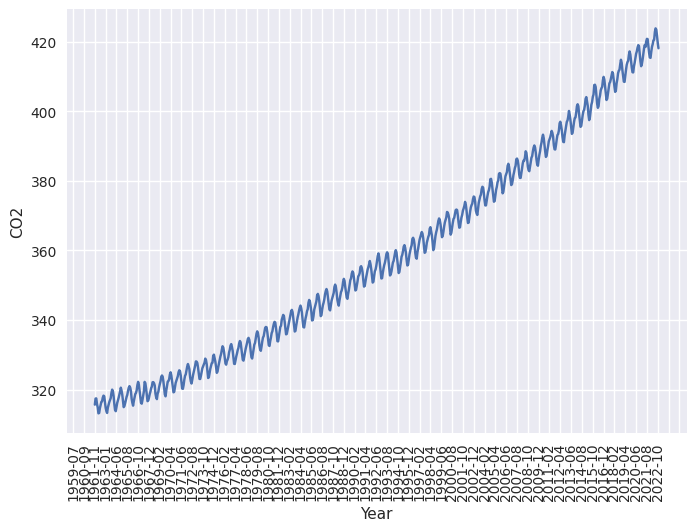

In [16]:
fig, ax = plt.subplots()
ax.plot(data["date"], data["CO2"])
ax.set_xlabel("Year")
ax.set_ylabel("CO2")
ax.set_xticklabels(ax.get_xticklabels()[::14], rotation=90)
locator = mpl.ticker.MultipleLocator(15)
ax.xaxis.set_major_locator(locator)

In [17]:
x = data.date.values.tolist()
y = torch.tensor(data.CO2.values).float()

In [18]:
ytrain = y

In [19]:
yvar, ymean = torch.var_mean(ytrain)
yvar, ymean

(tensor(962.1698), tensor(358.5257))

In [20]:
ytrain.std()

tensor(31.0189)

In [21]:
ytrain_norm = (ytrain  - ymean) / yvar.sqrt()

In [22]:
ytrain_norm.mean(), ytrain_norm.std()

(tensor(4.9986e-07), tensor(1.))

In [23]:
ytrain_norm[::100]

tensor([-1.3803, -1.2091, -0.8126, -0.5199, -0.1204,  0.4205,  0.8229,  1.4815])

In [24]:
ytrain_norm = ytrain_norm#[:25]

In [25]:
transition_matrix = torch.tensor([[1., 1.], [0, 1]])
obs_matrix = torch.tensor([1., 0])

In [26]:
dist.LogNormal(-20000., 1).sample()

tensor(0.)

In [27]:
def model(is_training=True):
    z = pyro.sample("z", dist.Normal(torch.tensor([0.0, 0.0]), torch.tensor([1., 1.])).to_event(1))
    # print('z0 ', z)
    # μ = pyro.sample("μ", dist.LogNormal(0, 1.))
    # δ = pyro.sample("δ", dist.LogNormal(0, 1.))
    # ϵ = pyro.sample("ϵ", dist.LogNormal(0, 1.))
    μₚ = pyro.sample("μ", dist.LogNormal(0., 1.))  
    δₚ = pyro.sample("δ", dist.LogNormal(0., 1.))  
    ϵₚ = pyro.sample("ϵ", dist.LogNormal(0., 1.))  
    data_plate =  pyro.plate("data", len(ytrain_norm))
    # for t in pyro.markov(range(len(list(data_plate)))):
    for t in pyro.markov(range(len(ytrain_norm))):
        # μ = pyro.sample(f"latent_μ_{t}", dist.Normal(0., μₚ))
        # δ = pyro.sample(f"latent_δ_{t}", dist.Normal(0., δₚ))
        
        # z = transition_matrix @ z + torch.tensor([μ, δ])
        z = pyro.sample(f"latent_z_{t}", dist.Normal(transition_matrix @ z, torch.tensor([μₚ, δₚ])))
        
        # ϵ = pyro.sample(f"latent_ϵ_{t}", dist.Normal(0., ϵₚ))
        yobs = ytrain_norm[t] if is_training else None
        # print("Selected ϵ: ", ϵₚ, " mean: ", obs_matrix @ z)
        obs = pyro.sample(f"y_{t}", dist.Normal(obs_matrix @ z, ϵₚ ), obs=yobs)
    
    return obs

In [28]:
# pyro.clear_param_store()
# pyro.set_rng_seed(0)
# model_simp = (
#         poutine.block(model, 
#                     expose_fn=lambda x: "latent_z" not in x["name"]
#                       )
#         )
# def init_loc_fn(x):
#     print(x["name"])
#     if x["name"] == "z":
#         return torch.tensor([-1.5, 1e-3])
#     return torch.tensor(0.001)
  
# guide = AutoNormal(model_simp, init_loc_fn=init_loc_fn, init_scale=1.)
# with poutine.block(), poutine.trace(param_only=True) as param_capture:
#     guide()

In [29]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

def guide(is_training=True):
    z_loc = pyro.param("zloc", torch.tensor([-1.5, 1e-3]))
    z_scale = pyro.param("zscale", torch.tensor([0.1, 10]), constraint=dist.constraints.positive)
    z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
    
    for n in ["μ","δ", "ϵ"]:
        loc = pyro.param(f"{n}loc", torch.tensor(1e-3))
        scale = pyro.param(f"{n}scale", torch.tensor(10), constraint=dist.constraints.positive)
        d = pyro.sample(f"{n}", dist.LogNormal(loc, scale))
    

In [30]:
with poutine.block(), poutine.trace(param_only=True) as param_capture:
    guide()

In [31]:
# pyro.get_param_store().__setitem__('z',  torch.tensor([1.0, 1e-3]))

In [32]:
list(pyro.get_param_store().items())

[('zloc', tensor([-1.5000e+00,  1.0000e-03], requires_grad=True)),
 ('zscale', tensor([ 0.1000, 10.0000], grad_fn=<AddBackward0>)),
 ('μloc', tensor(0.0010, requires_grad=True)),
 ('μscale', tensor(10., grad_fn=<AddBackward0>)),
 ('δloc', tensor(0.0010, requires_grad=True)),
 ('δscale', tensor(10., grad_fn=<AddBackward0>)),
 ('ϵloc', tensor(0.0010, requires_grad=True)),
 ('ϵscale', tensor(10., grad_fn=<AddBackward0>))]

In [33]:
params = list([pyro.param(name).unconstrained() for name in param_capture.trace])
optimizer = torch.optim.Adam(params, lr=1e-2)
print(list(pyro.get_param_store().items()))

[('zloc', tensor([-1.5000e+00,  1.0000e-03], requires_grad=True)), ('zscale', tensor([ 0.1000, 10.0000], grad_fn=<AddBackward0>)), ('μloc', tensor(0.0010, requires_grad=True)), ('μscale', tensor(10., grad_fn=<AddBackward0>)), ('δloc', tensor(0.0010, requires_grad=True)), ('δscale', tensor(10., grad_fn=<AddBackward0>)), ('ϵloc', tensor(0.0010, requires_grad=True)), ('ϵscale', tensor(10., grad_fn=<AddBackward0>))]


In [34]:
def train(i):
    guide_trace = poutine.trace(guide).get_trace()
    model_trace = poutine.trace( poutine.replay(model, trace=guide_trace)).get_trace() 
    
    elbo_loss = 0
    
    for name, node in model_trace.nodes.items():
        if node["type"] != "sample":
            continue
        elbo_loss += node["fn"].log_prob(node["value"]).sum()
        if  name in guide_trace.nodes:
            elbo_loss -=  guide_trace.nodes[name]["fn"].log_prob(guide_trace.nodes[name]["value"]).sum()
            
    return -elbo_loss

In [35]:
losses = []
for i in range(20000):
    loss = train(i) / len(ytrain_norm)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(params, 10.)
    optimizer.step()
    losses.append(loss.item())
    

ValueError: Expected parameter loc (Tensor of shape ()) of distribution Normal(loc: nan, scale: nan) to satisfy the constraint Real(), but found invalid values:
nan
Trace Shapes:    
 Param Sites:    
         zloc 2  
       zscale 2  
         μloc    
       μscale    
         δloc    
       δscale    
         ϵloc    
       ϵscale    
Sample Sites:    
       z dist | 2
        value | 2
       μ dist |  
        value |  
       δ dist |  
        value |  

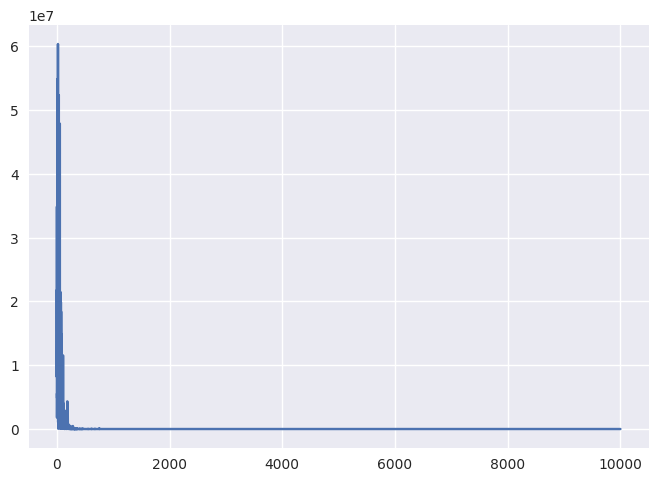

In [ ]:
plt.plot(losses)

In [ ]:
losses[-10:]

[12.46843433380127,
 10.655694007873535,
 12.819190979003906,
 12.951011657714844,
 15.791682243347168,
 13.774538040161133,
 15.681482315063477,
 12.237618446350098,
 14.269937515258789,
 11.619881629943848]

In [ ]:
print(list(pyro.get_param_store().items()))

[('zloc', tensor([-0.0122,  0.1575], requires_grad=True)), ('zscale', tensor([0.9768, 0.6016], grad_fn=<AddBackward0>)), ('μloc', tensor(-0.0923, requires_grad=True)), ('μscale', tensor(0.9466, grad_fn=<AddBackward0>)), ('δloc', tensor(-0.0132, requires_grad=True)), ('δscale', tensor(1.0541, grad_fn=<AddBackward0>)), ('ϵloc', tensor(9.5548, requires_grad=True)), ('ϵscale', tensor(0.0531, grad_fn=<AddBackward0>))]


In [ ]:
def predict():
    def run_model():
        model(False)
    guide_trace = poutine.trace(guide).get_trace()
    model_trace = poutine.trace( poutine.replay(run_model, trace=guide_trace)).get_trace()
    values = [] 
    for name, node in model_trace.nodes.items():
        if "y" in name:
            values.append(node["value"])
    return torch.hstack(values)

In [ ]:
predict()

tensor([-4.2356e+02, -4.9468e+02, -1.1629e+04, -9.5322e+02,  1.0540e+04,
         2.2574e+03, -3.0769e+04,  1.3951e+04,  4.5144e+03,  1.0491e+04,
         5.2556e+03, -2.1763e+04,  1.7465e+03,  3.7220e+03,  3.2314e+03,
        -4.6058e+03, -1.0535e+04, -7.1317e+03, -1.0737e+04, -6.6410e+03,
        -2.7978e+04,  1.8476e+04, -4.9249e+04, -5.0545e+03, -1.6939e+02,
        -1.3893e+04,  1.0178e+04, -2.0368e+04,  2.5298e+04, -1.4261e+04,
         1.6482e+04,  1.1448e+04, -2.5389e+03, -1.2768e+04, -1.1126e+04,
        -7.3165e+03, -6.2747e+02, -3.2618e+04,  1.6146e+03, -2.0608e+04,
         1.8256e+04,  7.8765e+03, -2.0791e+03,  7.7292e+03,  1.1221e+04,
        -2.2436e+04,  1.5793e+04,  4.0516e+03,  3.7034e+03,  8.7473e+03,
         2.3156e+03, -2.9362e+04,  1.2667e+04, -1.5911e+04, -6.2732e+03,
         1.5333e+03,  1.4877e+04, -2.7563e+03, -1.1674e+04, -1.6159e+04,
         1.1202e+03, -3.0680e+04, -9.2378e+03, -2.0397e+04,  1.4510e+04,
        -1.5296e+04, -1.5525e+04, -8.3090e+03, -1.4